# ARIMA Model Workflow

This notebook outlines the standard workflow for building an ARIMA model for time series forecasting.

## Steps:
1. **Load Data**: Import time series data.
2. **Preprocessing**: specific datetime conversions and index setting.
3. **Visual Inspection**: Plot the series to identify trends/seasonality.
4. **Stationarity Test**: Use Augmented Dickey-Fuller (ADF) test.
5. **Differencing**: Make the series stationary if needed.
6. **ACF/PACF Analysis**: Determine ARIMA(p,d,q) parameters.
7. **Model Fitting**: Fit the ARIMA model.
8. **Diagnostics**: Check residuals.
9. **Forecasting**: Predict future values.

## 1. Load Data
Replace 'path/to/your/data.csv' with your actual data file. Ensure you have a date column and a value column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 1. Download Real Data (WTI Crude Oil Continuous Contract)
# 'CL=F' is the ticker for Crude Oil Futures
data = yf.download('CL=F', start='2020-01-01', end='2024-01-01')

# Handle MultiIndex columns (yfinance update)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# We only need the 'Close' price
df = data[['Close']].copy()



C:\Users\JULONG\AppData\Local\Temp\ipykernel_17616\35956009.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('CL=F', start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


## 2. Visual Inspection

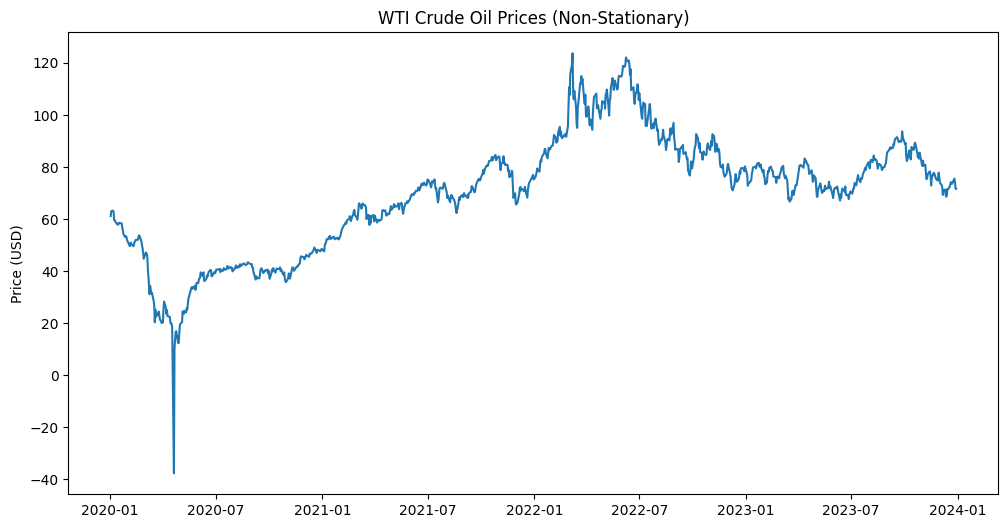

In [2]:
# 2. Visualize
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'])
plt.title('WTI Crude Oil Prices (Non-Stationary)')
plt.ylabel('Price (USD)')
plt.show()

## 3. Stationarity Test (ADF)

ARIMA requires stationary data. We use the Augmented Dickey-Fuller (ADF) Test.

The Theory:
1. Null Hypothesis ($H_0$): The series has a unit root (it is non-stationary)
2. Alternate Hypothesis ($H_1$): The series is stationary
3. Rule: If p-value < 0.05, we reject $H_0$ (Data is good). If > 0.05, we must difference the data.

In [3]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Conclusion: Stationary (d=0)")
    else:
        print("Conclusion: Non-Stationary (needs differencing)")

# Check original data
print("--- Checking Original Data ---")
check_stationarity(df['Close'])

--- Checking Original Data ---
ADF Statistic: -1.456886504811229
p-value: 0.5547210588046367
Conclusion: Non-Stationary (needs differencing)


## 4. Differencing

Since the data failed the test, we apply First Differencing ($d=1$). This subtracts today's price from yesterday's ($Y_t - Y_{t-1}$).

In [4]:
# Apply First Differencing
df['diff_1'] = df['Close'].diff()

# Drop the first NaN value created by differencing
df_diff = df.dropna()

# Check Stationarity again
print("\n--- Checking Differenced Data ---")
check_stationarity(df_diff['diff_1'])


--- Checking Differenced Data ---
ADF Statistic: -22.341630090683996
p-value: 0.0
Conclusion: Stationary (d=0)


## 5. Determine p (AR) and q (MA) Terms

Now we determine the lag order using ACF (Autocorrelation) and PACF (Partial Autocorrelation) plots.

The Theory:
1. ACF: Helps identify the MA($q$) term. Look for where the correlation drops off (cuts off)
2. PACF: Helps identify the AR($p$) term. Look for where the correlation cuts off sharply


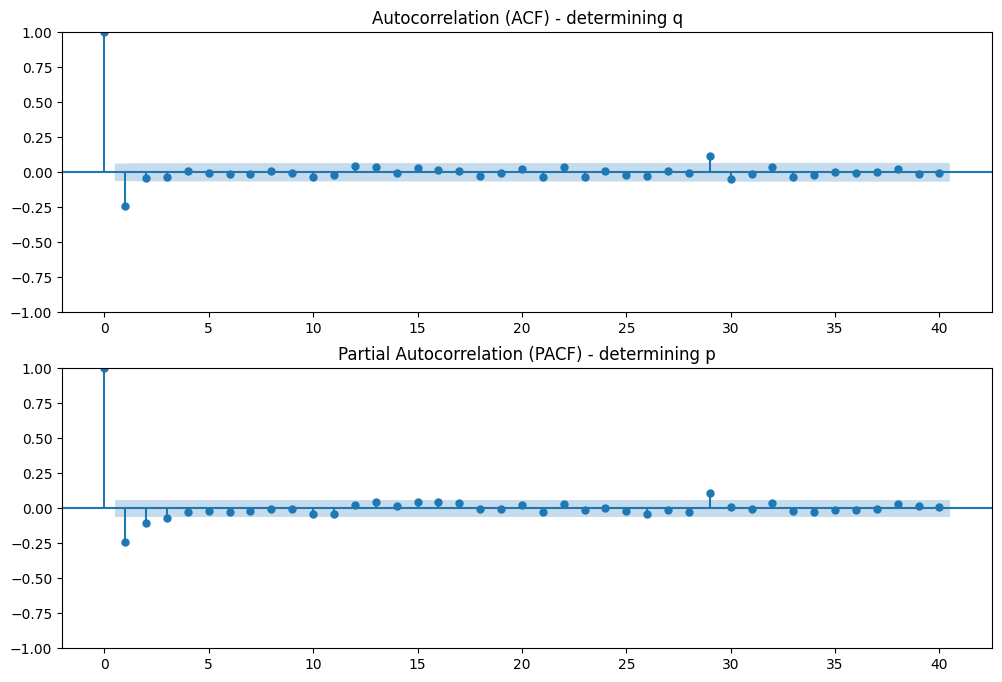

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot ACF (for q)
plot_acf(df_diff['diff_1'], ax=ax1, lags=40)
ax1.set_title('Autocorrelation (ACF) - determining q')

# Plot PACF (for p)
plot_pacf(df_diff['diff_1'], ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation (PACF) - determining p')

plt.show()

How to Read the Plots for Oil:
- If the PACF shows a sharp spike at lag 1 and then nothing, it suggests $p=1$.
- If the ACF shows a gradual decline or a spike at lag 1, it suggests $q=1$.
- Pro Tip: For crude oil, an ARIMA(1, 1, 1) is a very common starting baseline7. 

## 6. Fitting the ARIMA Model

We will now fit the model. We'll split the data into "Train" (history) and "Test" (future we want to predict) to evaluate performance honestly.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Split Data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Define the Model
# We use order=(p,d,q). Let's try (1,1,1) based on literature.
model = ARIMA(train, order=(1, 1, 1))

# Fit the Model
model_fit = model.fit()

# Print Summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  804
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2072.942
Date:                Fri, 19 Dec 2025   AIC                           4151.883
Time:                        14:08:28   BIC                           4165.948
Sample:                             0   HQIC                          4157.285
                                - 804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2459      0.051      4.820      0.000       0.146       0.346
ma.L1         -0.5429      0.049    -10.998      0.000      -0.640      -0.446
sigma2        10.2262      0.066    155.662      0.0

c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Critical Checks in Summary:
1. P>|z| (P-Value of coefficients): Ideally, these should be < 0.05. If they are high, that term (AR or MA) might not be needed.
2. AIC: Lower is better. You can try changing $(1,1,1)$ to $(2,1,1)$ and see if AIC drops8

## 7. Forecasting & Evaluation

Now we predict the prices for the test set range.

c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


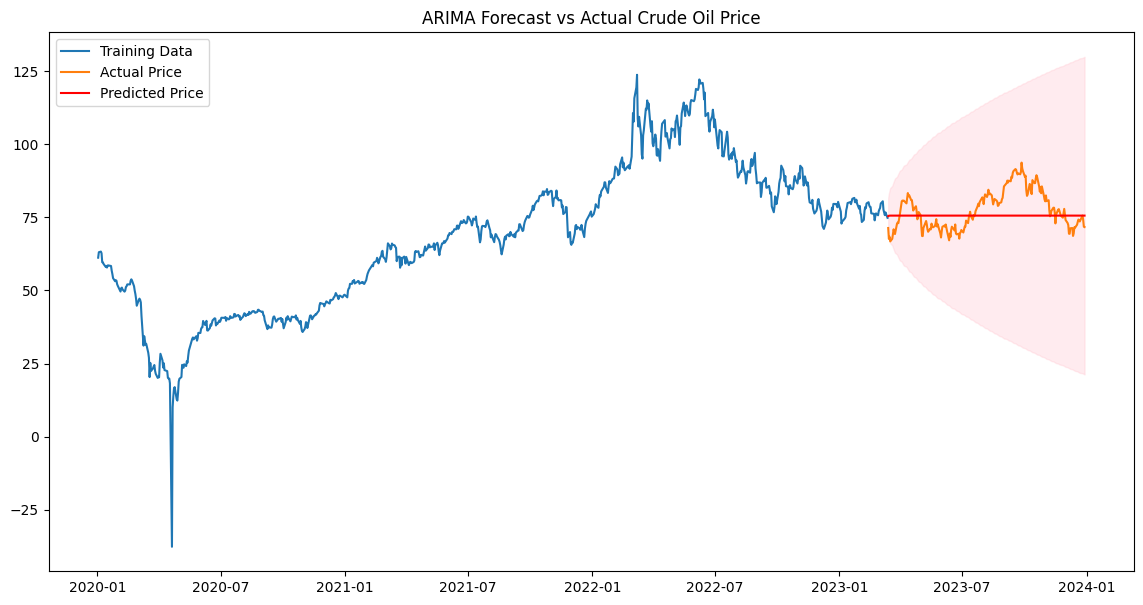

In [7]:
# Forecast
forecast_steps = len(test)
forecast_result = model_fit.get_forecast(steps=forecast_steps)

# Extract forecast and confidence intervals
forecast_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Make it plot-friendly
forecast_series.index = test.index
conf_int.index = test.index

# Plot Results
plt.figure(figsize=(14,7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Price')
plt.plot(forecast_series.index, forecast_series, label='Predicted Price', color='red')
plt.fill_between(forecast_series.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast vs Actual Crude Oil Price')
plt.legend()
plt.show()

## 8. Diagnostic Check (Residuals)

Before trusting the model, check the residuals (errors). They should look like White Noise (random, mean 0).

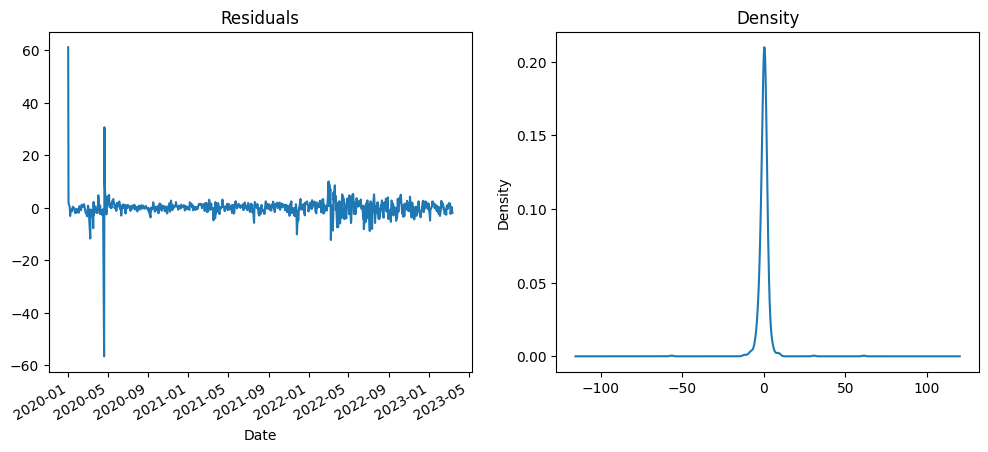

     lb_stat  lb_pvalue
10  2.099613   0.995518


In [8]:
# 1. Plot Residuals
residuals = model_fit.resid
fig, ax = plt.subplots(1,2, figsize=(12,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title="Density", ax=ax[1])
plt.show()

# 2. Ljung-Box Test (Statistical check for white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

 Result Interpretation: 
- If lb_pvalue > 0.05, your residuals are random (Good!). 
- If lb_pvalue < 0.05, there is still information left in the data that your model missed (likely volatility clustering/GARCH effects).

# Summary of Results

1. RMSE (Root Mean Squared Error): Calculate this to quantify error.

In [9]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast_series))
print(f'RMSE: {rmse}')

RMSE: 6.887218802851145


Result (6.88): 
- This tells you that, on average, your model's price prediction is off by about $6.89.
- If oil is $75, your model typically guesses somewhere between $68 and $82.
- Unit: This is in valid Dollars (USD).

2. Expectation: For crude oil, don't be surprised if the forecast looks like a straight line or a slow curve. ARIMA is great at short-term momentum but bad at predicting sudden shocks (like OPEC announcements).

# Part 2: Automated Grid Search via AutoARIMA

# 1: Automated Grid Search
We will use the auto_arima function. We explicitly turn off seasonality (seasonal=False) because, as noted in the text, ARIMA often outperforms SARIMA for crude oil due to weak statistical seasonality.

In [10]:
import pmdarima as pm

# 1. Run Auto-ARIMA
# We assume 'train' is your training data from the previous step
print("Starting Auto-ARIMA search...")

model_auto = pm.auto_arima(
    train,
    start_p=0, start_q=0,       # Start search at 0
    max_p=5, max_q=5,           # Max lag to test (rarely go above 5 for oil)
    d=None,                     # Let model determine 'd' (differencing)
    seasonal=False,             # Crude oil price is often treated as non-seasonal 
    stepwise=True,              # Uses a smart search (faster than checking EVERY combination)
    suppress_warnings=True,
    error_action="ignore",
    trace=True                  # Prints the results as it tries them
)

print("\nBest Model Found:")
print(model_auto.summary())

Starting Auto-ARIMA search...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4221.929, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4168.194, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4155.866, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4219.950, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4153.819, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4154.864, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4154.803, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4154.711, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4159.818, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4156.802, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4151.883, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4153.914, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4166.229, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4152.938, Time=0.08 sec
 AR

What to look for in the Output:

- Best Model: It might pick something like ARIMA(2,1,2) instead of our manual (1,1,1).

- AIC Score: Compare this to the manual model. A lower AIC indicates a better balance of accuracy and simplicity.

# 2. Diagnostic Plots
Automated models must still be "sanity checked" to ensure the residuals (errors) are white noise

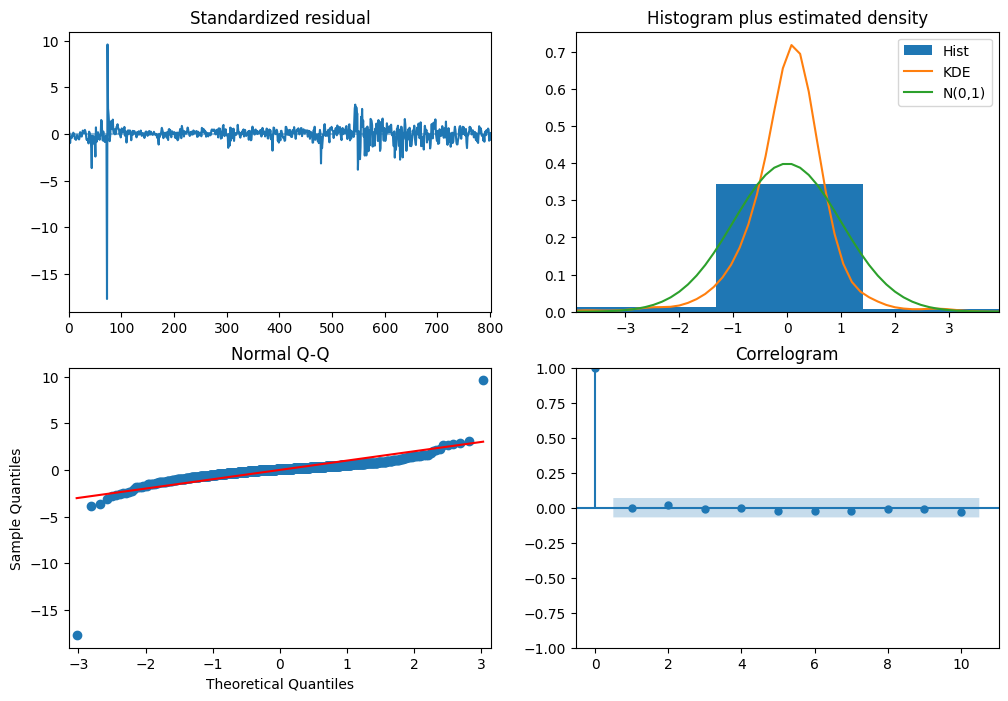

In [11]:
# Create diagnostic plots automatically
model_auto.plot_diagnostics(figsize=(12, 8))
plt.show()

Checklist for these plots:

1. Standardized Residuals: Should look like random static (no patterns).

2. Histogram: Should look like a Bell Curve (Normal Distribution). Note: Crude oil often has "fat tails" (extreme outliers), so it might not be perfect.

3. Correlogram (ACF): No blue bars should extend beyond the shaded region. If they do, information is leaking.

4. Q-Q Plot: Dots should follow the red line. Deviations at the ends indicate "heavy tails" (shocks/crashes).

# 3. Diagnostic Plots

c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


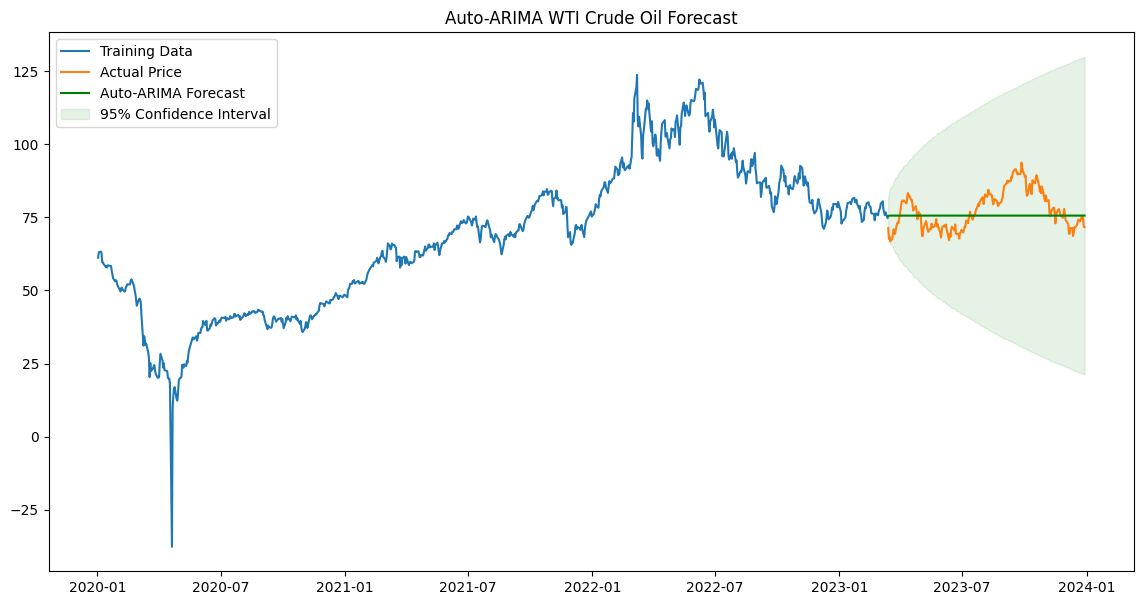

In [12]:
# Forecast
forecast_values, conf_int = model_auto.predict(n_periods=len(test), return_conf_int=True)

# Visualize
plt.figure(figsize=(14,7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, forecast_values, label='Auto-ARIMA Forecast', color='green')

# Confidence Interval (The "Cone of Uncertainty")
plt.fill_between(test.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='green', alpha=0.1, label='95% Confidence Interval')

plt.title('Auto-ARIMA WTI Crude Oil Forecast')
plt.legend()
plt.show()

# 4. The "Rolling Forecast" (Essential for Oil)
Predicting 30 days out in one go is dangerous for oil because the error compounds. A Rolling Forecast is how professionals do it: you predict 1 day, get the real price, add it to your history, and then predict the next day. This mimics real-life trading.

Running Rolling Forecast for 202 days...
Rolling Forecast RMSE: 1.7633


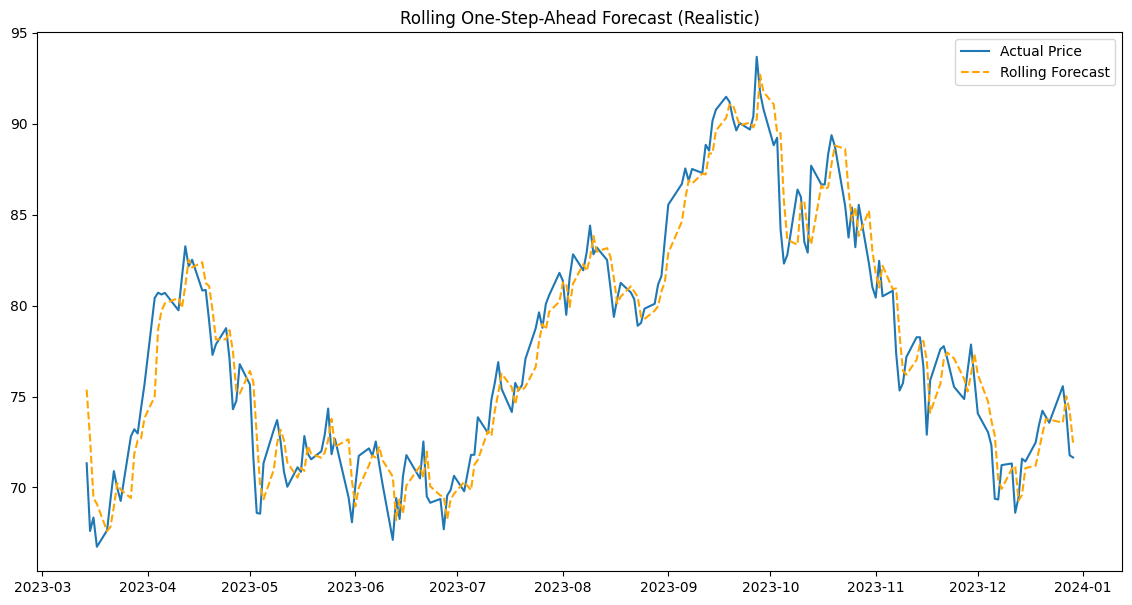

In [13]:
from sklearn.metrics import mean_squared_error

# History starts as your training data
# Ensure history is a flat list of floats to avoid 'isnan' errors with dataframes
history = train.values.flatten().tolist()
predictions = []

print(f"Running Rolling Forecast for {len(test)} days...")

# Loop over each day in the test set
for t in range(len(test)):
    # 1. Fit model on current history
    # (We re-use the order found by auto_arima to save time, e.g., (2,1,2))
    try:
        model_rolling = ARIMA(history, order=model_auto.order).fit()

        # 2. Forecast next step (t+1)
        output = model_rolling.forecast()
        yhat = output[0]
        predictions.append(yhat)
    except Exception as e:
        print(f"ARIMA fit/forecast failed at step {t}: {e}")
        # Fallback: repeat last observation or append Nan
        predictions.append(history[-1] if len(history)>0 else 0)

    # 3. Add the *actual* observed value to history for the next loop
    obs = test.iloc[t]
    if hasattr(obs, 'item'):
        obs = obs.item()
    history.append(obs)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Rolling Forecast RMSE: {rmse:.4f}')

# Plotting the Rolling Forecast
plt.figure(figsize=(14,7))
plt.plot(test.index, test, label='Actual Price')
plt.plot(test.index, predictions, label='Rolling Forecast', color='orange', linestyle='--')
plt.title('Rolling One-Step-Ahead Forecast (Realistic)')
plt.legend()
plt.show()